In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [62]:
# df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
# X = df.drop('target', axis=1)
# y = df['target']

# from sklearn.dummy import DummyClassifier
# model = DummyClassifier().fit(X, y)

# X_test = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')
# y_pred = model.predict(X_test)

# submission = pd.DataFrame({'id': range(0, X_test.shape[0]),
#                            'target': y_pred})

# submission.to_csv('submission.csv', index=False)

In [63]:
import sys
import warnings
if not sys.warnoptions:
    # To ignore warinings
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

### Importing neccessary libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

In [65]:
def clip_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound
        upper_bound = Q3 + 1.5 * IQR  # Upper bound
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

### Data Loading

In [66]:
train_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

In [67]:
train_df.shape, test_df.shape

((39211, 16), (10000, 15))

### Exploratory Data Analysis

#### Statistical Analysis

In [8]:
train_df.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [9]:
train_df.sample(5)

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
32355,2010-10-19,61,technician,divorced,secondary,no,6481,no,no,cellular,131,1,-1,0,NaN,yes
2473,2009-04-20,32,management,married,tertiary,no,3154,no,no,cellular,96,2,150,2,failure,no
13398,2010-11-18,40,technician,married,secondary,no,5811,yes,no,cellular,172,1,-1,0,NaN,no
1703,2009-01-24,44,entrepreneur,married,primary,no,23413,no,no,cellular,3478,52,141,71,success,no
35949,2009-05-14,54,blue-collar,married,secondary,no,219,yes,no,NaN,341,5,-1,0,NaN,no


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [11]:
train_df.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [12]:
train_df.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [13]:
train_df.duplicated().sum()

0

In [14]:
# Get the unique values in each categorical feature
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

for feature in categorical_features:
    unique_values = train_df[feature].unique()
    print(f"Unique values in '{feature}': {unique_values}")

Unique values in 'job': ['blue-collar' 'technician' 'admin.' 'entrepreneur' 'unemployed'
 'management' 'services' 'student' 'self-employed' 'retired' 'housemaid'
 nan]
Unique values in 'marital': ['married' 'single' 'divorced']
Unique values in 'education': ['secondary' 'tertiary' 'primary' nan]
Unique values in 'default': ['no' 'yes']
Unique values in 'housing': ['yes' 'no']
Unique values in 'loan': ['no' 'yes']
Unique values in 'contact': ['cellular' 'telephone' nan]
Unique values in 'poutcome': ['other' nan 'failure' 'success']


In [15]:
# Checking unique values for numerical features
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

for feature in numerical_features:
    unique_count = train_df[feature].nunique()
    print(f"Number of unique values in '{feature}': {unique_count}")

Number of unique values in 'age': 78
Number of unique values in 'balance': 9535
Number of unique values in 'duration': 3146
Number of unique values in 'campaign': 63
Number of unique values in 'pdays': 865
Number of unique values in 'previous': 276


In [16]:
# Get the distribution of categorical features
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

for feature in categorical_features:
    print(f"\nDistribution of {feature}:\n", train_df[feature].value_counts())


Distribution of job:
 job
blue-collar      7776
management       7462
technician       6078
admin.           4116
services         3325
self-employed    1862
retired          1824
entrepreneur     1805
unemployed       1685
housemaid        1656
student          1393
Name: count, dtype: int64

Distribution of marital:
 marital
married     22691
single      11250
divorced     5270
Name: count, dtype: int64

Distribution of education:
 education
secondary    19584
tertiary     11615
primary       6545
Name: count, dtype: int64

Distribution of default:
 default
no     36954
yes     2257
Name: count, dtype: int64

Distribution of housing:
 housing
yes    21657
no     17554
Name: count, dtype: int64

Distribution of loan:
 loan
no     31820
yes     7391
Name: count, dtype: int64

Distribution of contact:
 contact
cellular     25030
telephone     3845
Name: count, dtype: int64

Distribution of poutcome:
 poutcome
failure    4949
other      2560
success    2251
Name: count, dtype: int64


#### Data Visualisation

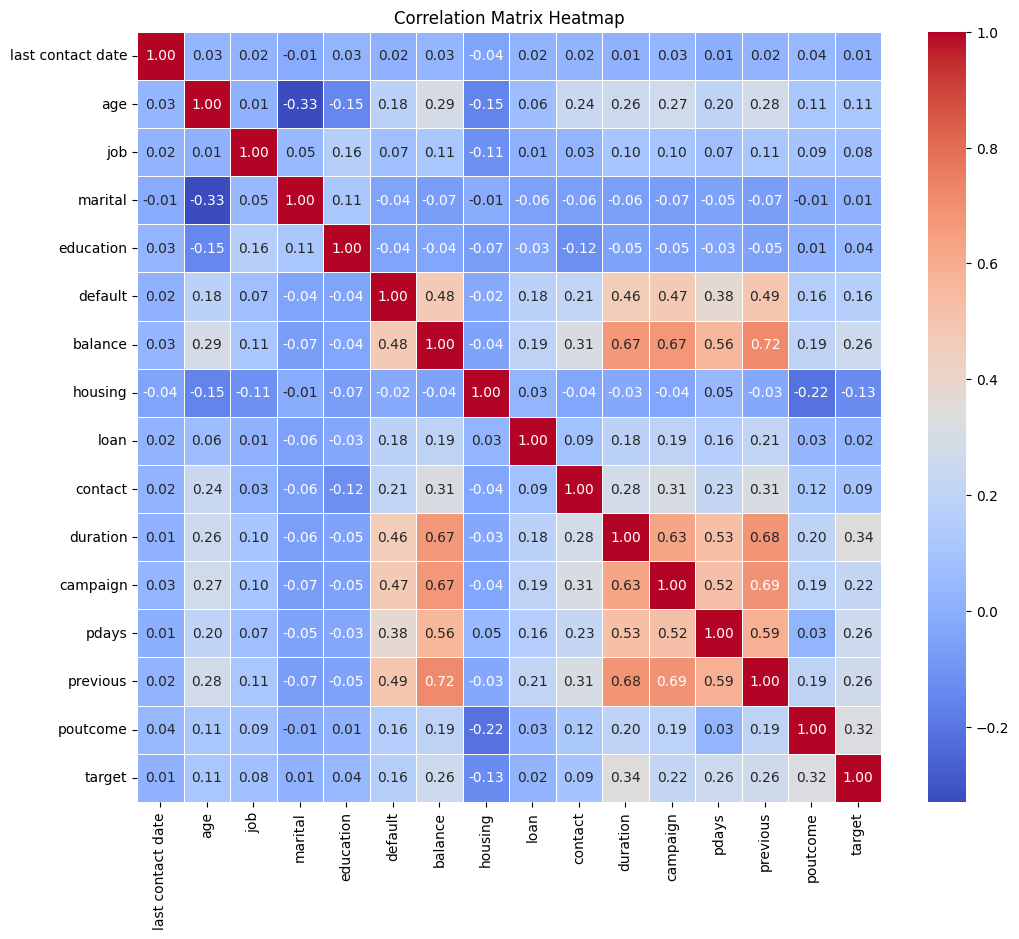

In [17]:
# Create a copy of train_df
train_df_eda = deepcopy(train_df)

# Convert 'last contact date' column to datetime format
train_df_eda['last contact date'] = pd.to_datetime(train_df_eda['last contact date'])

# Encode categorical columns
categorical_columns = ['job', 'marital', 'education', 'contact', 'poutcome', 'default', 'housing', 'loan', 'target']
ordinal_encoder = OrdinalEncoder()
train_df_eda[categorical_columns] = ordinal_encoder.fit_transform(train_df_eda[categorical_columns])

# Calculate the Pearson correlation matrix
corr_matrix = train_df_eda.corr(method='pearson')

# Plot as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

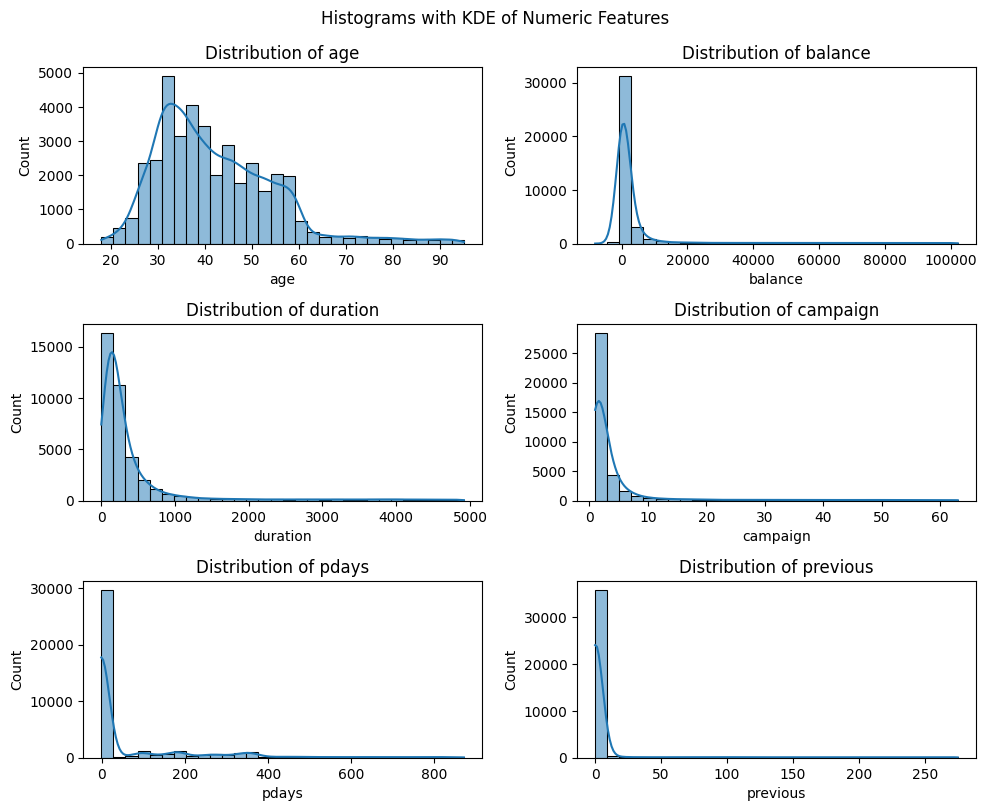

In [18]:
# Set up the plotting area
plt.figure(figsize=(10, 10))

# Plot each numeric feature's histogram with a KDE line
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features) // 2 + 1, 2, i)  # Arrange plots in a grid
    sns.histplot(train_df[feature], bins=30, kde=True)  # kde=True for KDE overlay
#     sns.distplot(train_df[feature], bins=30)
    plt.title(f'Distribution of {feature}')


plt.tight_layout()
plt.suptitle('Histograms with KDE of Numeric Features', y=1.02)
plt.show()

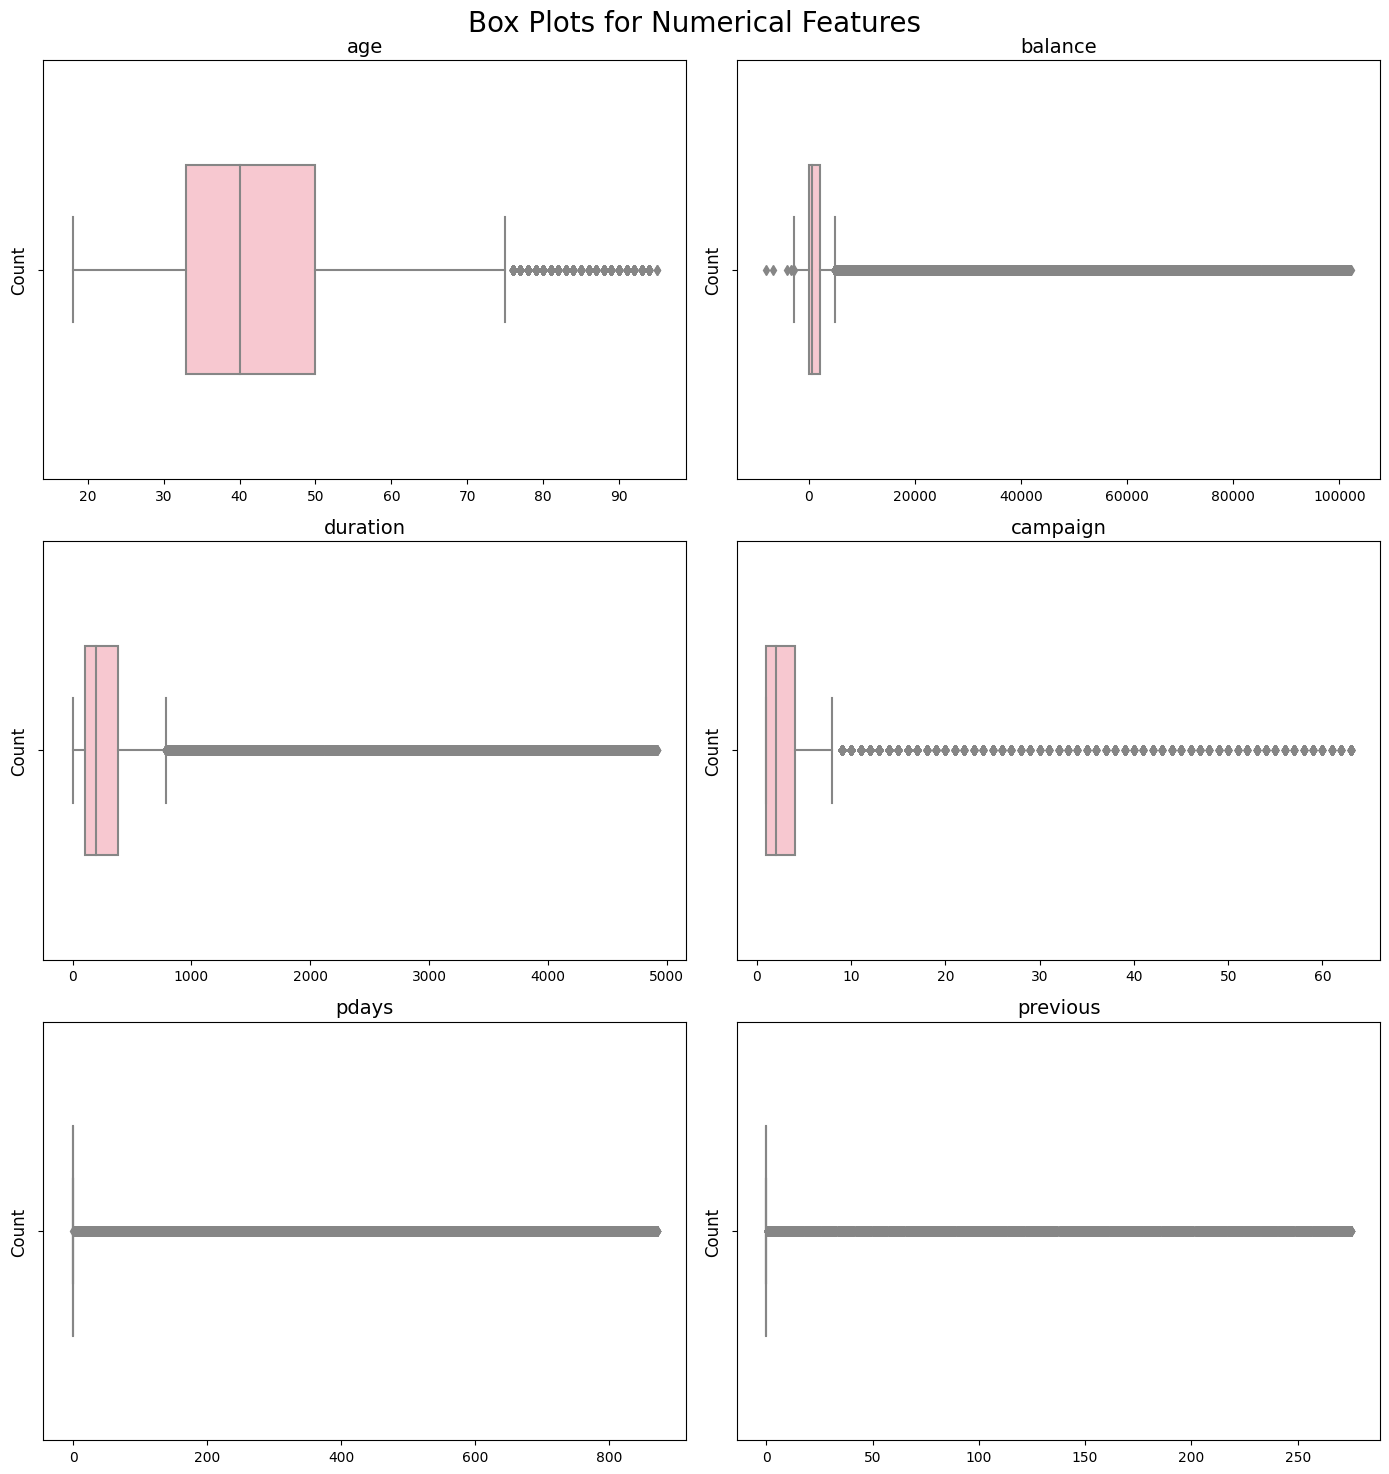

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
axes = axes.ravel()

# Plotting box plots for each numerical feature
for i, column in enumerate(numerical_features):
    sns.boxplot(x=column, data=train_df, color='pink', width=0.5, fliersize=5, ax=axes[i])
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('Count', fontsize=12)
plt.suptitle('Box Plots for Numerical Features', fontsize=20)
plt.tight_layout()
plt.show()

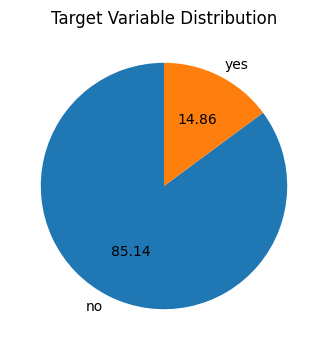

In [20]:
# targle distribution
target_counts = train_df['target'].value_counts()


plt.figure(figsize=(6, 4))
plt.pie(target_counts, labels=target_counts.index, autopct='%.2f', startangle=90)
plt.title('Target Variable Distribution')
plt.show()

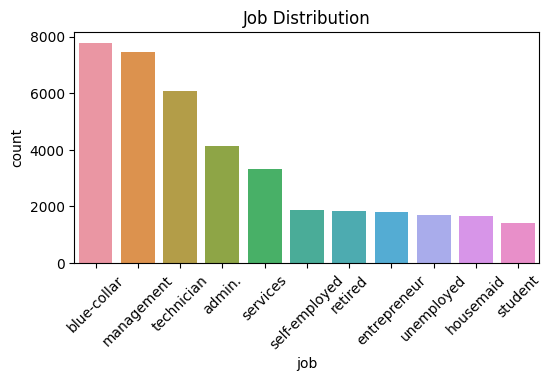

In [21]:
# job distribution
plt.figure(figsize=(6,3))
sns.countplot(x='job', data=train_df, order=train_df['job'].value_counts().index)
plt.title('Job Distribution')
plt.xticks(rotation=45)
plt.show()

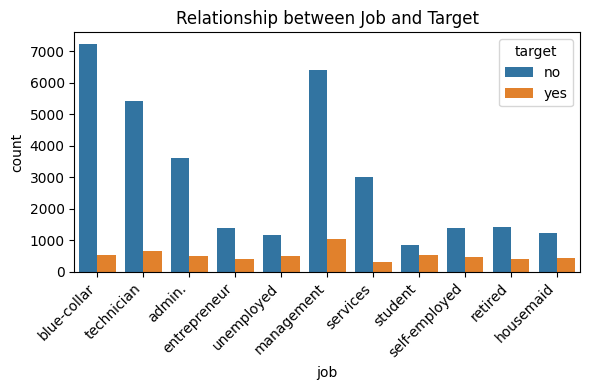

In [22]:
# relationship between job and target
plt.figure(figsize=(6,4))
sns.countplot(x='job', hue='target', data=train_df)
plt.title('Relationship between Job and Target')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout() 
plt.show()

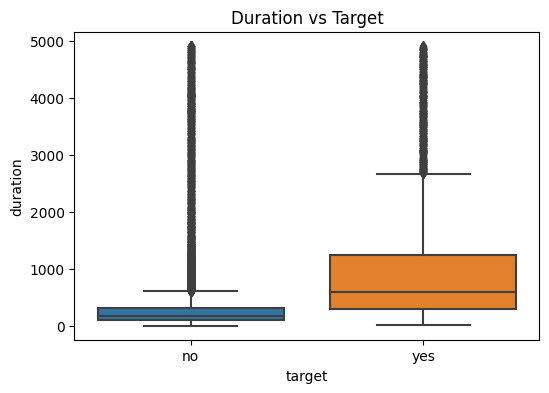

In [23]:
# boxplot of duration vs target 
plt.figure(figsize=(6,4))
sns.boxplot(x='target', y='duration', data=train_df)
plt.title('Duration vs Target')
plt.show()

In [24]:
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'])

<Figure size 640x480 with 0 Axes>

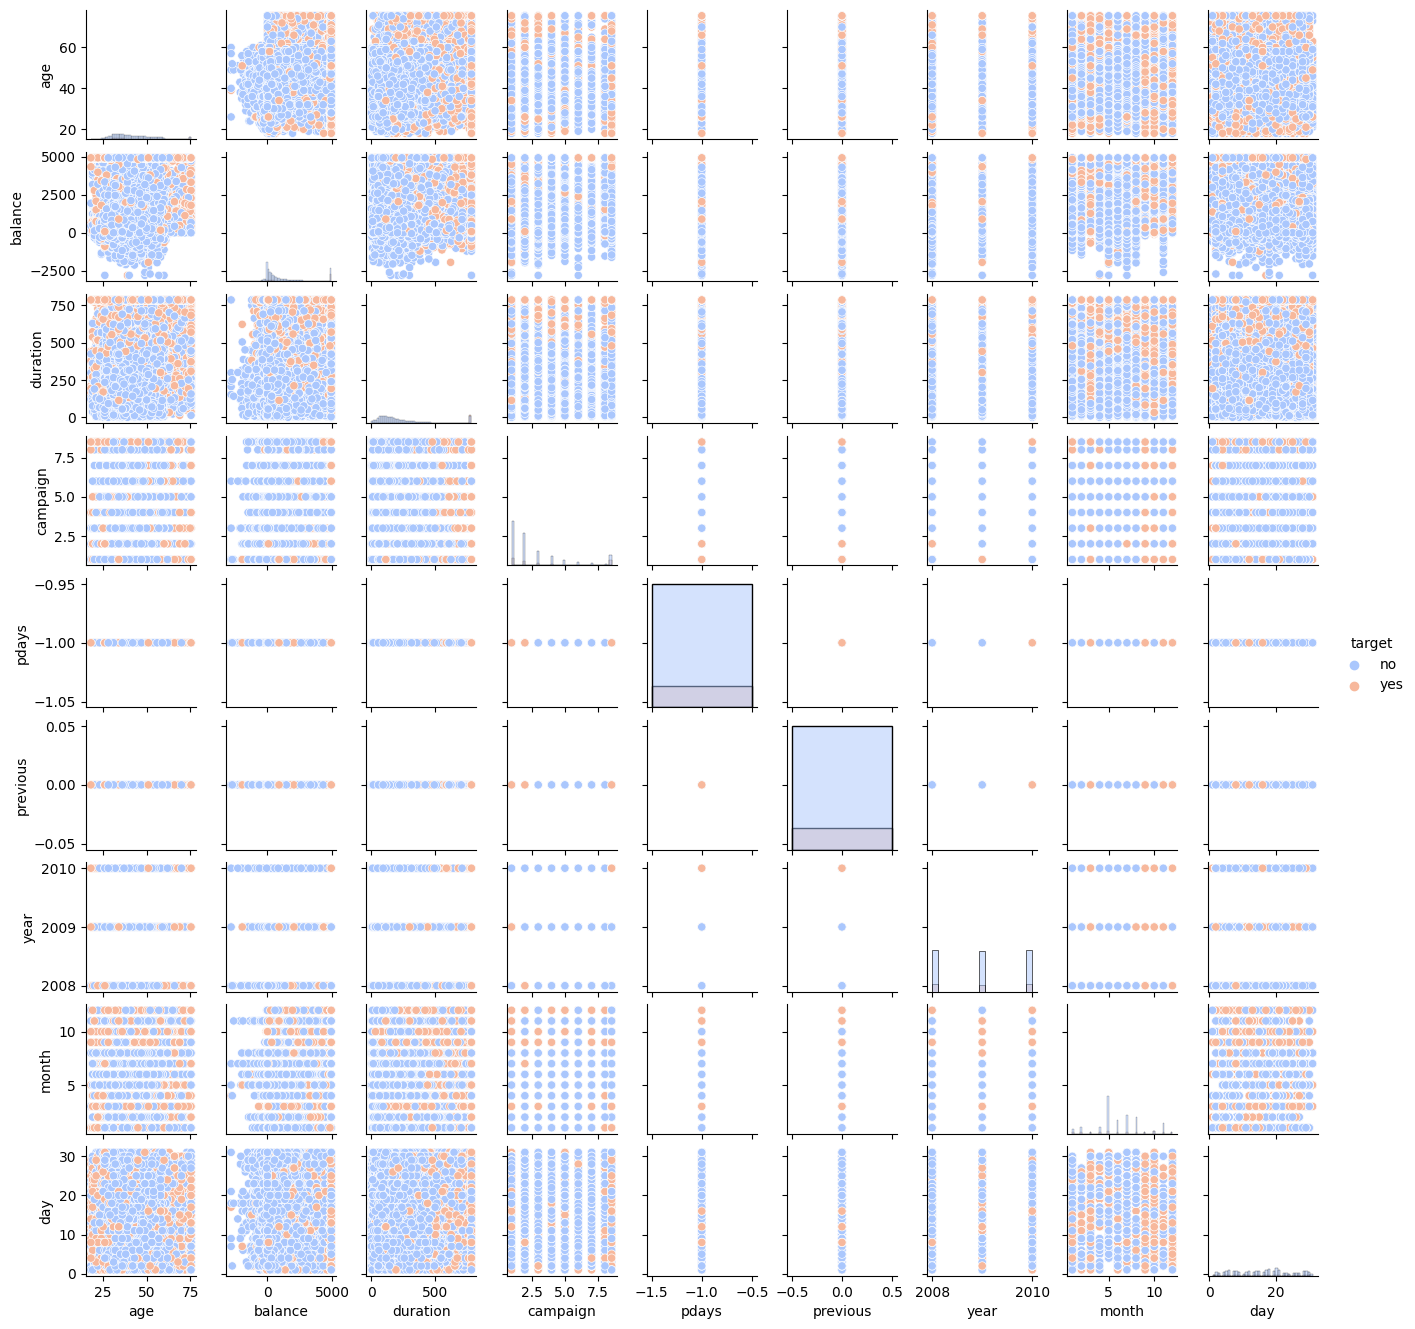

In [32]:
# pairplot of all features in train_df
plt.figure()
sns.pairplot(train_df, diag_kind="hist", hue="target", palette="coolwarm", height=1.5)
plt.show()

### Feature Engineering

In [68]:
# Ensure the 'last contact date' column is in datetime format
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'])

# Extracting features from the datetime column
train_df['date'] = train_df['last contact date'].dt.date  # Extract date
train_df['time'] = train_df['last contact date'].dt.time  # Extract time
train_df['year'] = train_df['last contact date'].dt.year  # Extract year
train_df['month'] = train_df['last contact date'].dt.month  # Extract month as number
train_df['month_name'] = train_df['last contact date'].dt.month_name()  # Extract month name
train_df['day'] = train_df['last contact date'].dt.day  # Extract day of the month
train_df['day_name'] = train_df['last contact date'].dt.day_name()  # Extract day name

train_df.drop(columns=['last contact date'], inplace=True)

In [69]:
# Ensure the 'last contact date' column is in datetime format
test_df['last contact date'] = pd.to_datetime(test_df['last contact date'])

# Extracting meaningful features from the datetime column
test_df['date'] = test_df['last contact date'].dt.date  # Extract date
test_df['time'] = test_df['last contact date'].dt.time  # Extract time
test_df['year'] = test_df['last contact date'].dt.year  # Extract year
test_df['month'] = test_df['last contact date'].dt.month  # Extract month as number
test_df['month_name'] = test_df['last contact date'].dt.month_name()  # Extract month name
test_df['day'] = test_df['last contact date'].dt.day  # Extract day of the month
test_df['day_name'] = test_df['last contact date'].dt.day_name()  # Extract day name

# Drop the original 'last contact date' column and redundant columns if necessary
test_df.drop(columns=['last contact date'], inplace=True)
# test_df.drop(columns=['date', 'month', 'day'], inplace=True)

In [70]:
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
train_df = clip_outliers_iqr(train_df, numerical_cols)
test_df = clip_outliers_iqr(test_df, numerical_cols)

### Train-Test Split

In [71]:
# droping target & `last contact date`
X = train_df.drop(columns=['target'])
y = train_df['target']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
X_train.shape, X_test.shape

((31368, 21), (7843, 21))

### Data Cleaning/ Preprocessing

In [74]:
# Get numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

numerical_cols, categorical_cols

(['age',
  'balance',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'year',
  'month',
  'day'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'poutcome',
  'date',
  'time',
  'month_name',
  'day_name'])

In [75]:
# Pipeline for numerical preprocessing: fill missing values and scale features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values
    ('scaler', StandardScaler())                             # Scale numerical features
])

numerical_pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [76]:
# Pipeline for categorical preprocessing: fill missing values and apply one-hot encoding
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-Hot Encoding
])

categorical_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [77]:
# Combine preprocessing pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

# Apply transformations to training, & test dataset
x_train_transformed = preprocessor.fit_transform(X_train, y_train)
x_test_transformed = preprocessor.transform(X_test)
test_transformed = preprocessor.transform(test_df)

### Building a Baseline Model (Logistic Regression)

In [54]:
# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(x_train_transformed,y_train)
          
# Predict on the test data
y_pred = model.predict(x_test_transformed)
          
# Print classification performance report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

          no       0.95      0.89      0.92      7057
         yes       0.38      0.58      0.46       786

    accuracy                           0.86      7843
   macro avg       0.66      0.74      0.69      7843
weighted avg       0.89      0.86      0.88      7843



### Ridge Classifier

In [72]:
# Initialize and train the RidgeClassifier model
model = RidgeClassifier(solver="lsqr")
model.fit(x_train_transformed, y_train)

# Predict on the test data
y_pred = model.predict(x_test_transformed)

# Print classification performance report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          no       0.96      0.89      0.92      7181
         yes       0.31      0.57      0.40       662

    accuracy                           0.86      7843
   macro avg       0.64      0.73      0.66      7843
weighted avg       0.90      0.86      0.88      7843



### AdaBoost Classifier

In [73]:
# Train AdaBoostClassifier model
model = AdaBoostClassifier(n_estimators=100)
model.fit(x_train_transformed, y_train)

# Predict and print report
y_pred = model.predict(x_test_transformed)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          no       0.95      0.89      0.92      7061
         yes       0.37      0.56      0.45       782

    accuracy                           0.86      7843
   macro avg       0.66      0.73      0.68      7843
weighted avg       0.89      0.86      0.87      7843



### Random Forest Classifier

In [74]:
# Train RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100)

# Encode target labels
y_train = y_train.map({'yes': 1, 'no': 0})
y_test = y_test.map({'yes': 1, 'no': 0})

# Fit and predict
model.fit(x_train_transformed, y_train)
y_pred = model.predict(x_test_transformed)

# Print report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      7240
           1       0.30      0.60      0.40       603

    accuracy                           0.86      7843
   macro avg       0.63      0.74      0.66      7843
weighted avg       0.91      0.86      0.88      7843



### Recursive Feature Elimination with Random Forest Classifier

In [ ]:
# model = RandomForestClassifier(n_estimators=100)

# rfe = RFE(estimator=model, n_features_to_select=5) # Select top 5 features
# rfe.fit(x_train_transformed, y_train)

# # Get the selected features
# selected_features = rfe.support_

# # Transform your data using only the selected features
# x_train_rfe = x_train_transformed[:, selected_features]
# x_test_rfe = x_test_transformed[:, selected_features]
# test_transformed_rfe = test_transformed[:, selected_features]


# # Train model on the selected features
# model.fit(x_train_rfe, y_train)

# # Make predictions
# y_pred_rfe = model.predict(x_test_rfe)

# # Print report
# print(classification_report(y_pred_rfe, y_test))

### GradientBoostingClassifier

In [19]:
# Train GradientBoostingClassifier model
model = GradientBoostingClassifier()

# Encode target labels
y_train = y_train.map({'yes': 1, 'no': 0})
y_test = y_test.map({'yes': 1, 'no': 0})

# Fit and predict/////////////////////////////////
model.fit(x_train_transformed, y_train)
y_pred = model.predict(x_test_transformed)

# Print report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      6965
           1       0.42      0.58      0.49       878

    accuracy                           0.86      7843
   macro avg       0.68      0.74      0.71      7843
weighted avg       0.89      0.86      0.87      7843



### Extreme Gradient Boosting

In [38]:
# Train XGBClassifier model
model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')

# Encode target labels
y_train = y_train.map({'yes': 1, 'no': 0})
y_test = y_test.map({'yes': 1, 'no': 0})

# Fit and predict
model.fit(x_train_transformed, y_train)
y_pred = model.predict(x_test_transformed)

# Print report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      6863
           1       0.45      0.56      0.50       980

    accuracy                           0.86      7843
   macro avg       0.69      0.73      0.71      7843
weighted avg       0.87      0.86      0.87      7843



### Light Gradient Boosting Machine

In [39]:
# Train LGBMClassifier model with scale_pos_weight
model = LGBMClassifier(scale_pos_weight=2, verbose=-1)

# Fit and predict
model.fit(x_train_transformed, y_train)
y_pred = model.predict(x_test_transformed)

# Print report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      6645
           1       0.54      0.74      0.62      1198

    accuracy                           0.86      7843
   macro avg       0.74      0.81      0.77      7843
weighted avg       0.89      0.86      0.87      7843



### Model Evaluation

In [78]:
# Models for training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(solver="lsqr"),
    "AdaBoost Classifier": AdaBoostClassifier(n_estimators=100),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "XGBoost Classifier": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM Classifier": LGBMClassifier(scale_pos_weight=2, verbose=-1)
}

results = {}

for name, model in models.items():
#     print(f"Training {name}...")
    
    #Handle target variable mapping if necessary
    if name in ["XGBoost Classifier", "Random Forest Classifier", "Gradient Boosting Classifier"]:
      y_train_temp = y_train.map({'yes': 1, 'no': 0})
      y_test_temp = y_test.map({'yes': 1, 'no': 0})
      model.fit(x_train_transformed, y_train_temp)
      y_pred = model.predict(x_test_transformed)
      f1 = f1_score(y_test_temp, y_pred, pos_label=1, average='macro') #Specify pos_label for these models
    else:
      y_train_temp = y_train
      y_test_temp = y_test
      model.fit(x_train_transformed, y_train_temp)
      y_pred = model.predict(x_test_transformed)
      f1 = f1_score(y_test_temp, y_pred, pos_label='yes', average='macro') #Specify pos_label for other models

    results[name] = f1
#     print(f"F1 Score for {name}: {f1:.5f}")

# Display results
print("\nF1 Scores Comparison(Macro Average):")
for name, f1 in results.items():
    print(f"{name}: {f1:.5f}")


F1 Scores Comparison(Macro Average):
Logistic Regression: 0.69014
Ridge Classifier: 0.66208
AdaBoost Classifier: 0.68267
Random Forest Classifier: 0.66541
Gradient Boosting Classifier: 0.70529
XGBoost Classifier: 0.70996
LightGBM Classifier: 0.76876


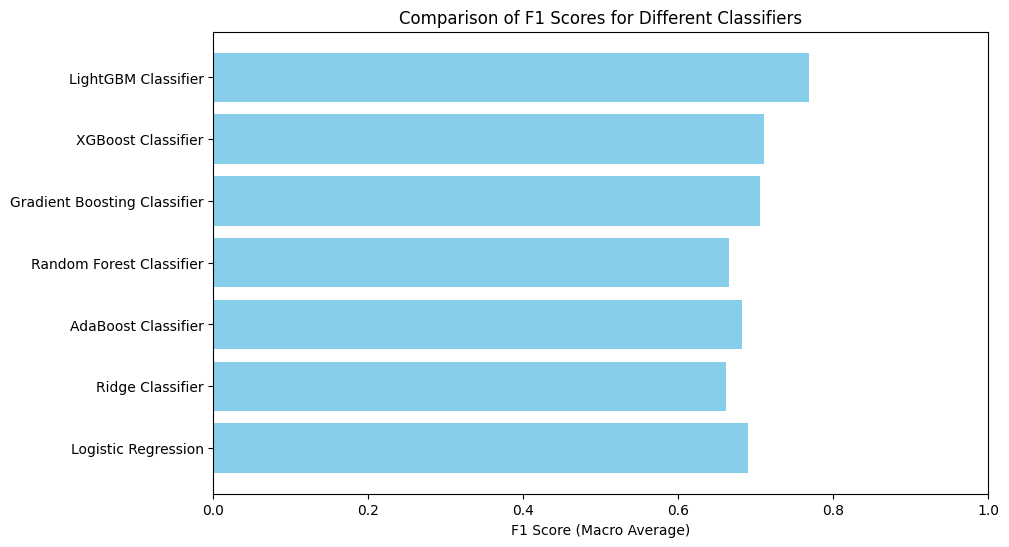

In [79]:
# Plot F1 scores comparison
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel('F1 Score (Macro Average)')
plt.title('Comparison of F1 Scores for Different Classifiers')
plt.xlim(0, 1)  # F1 score ranges from 0 to 1
plt.show()

### Hyperparameter Tuning

In [48]:
# best model for tuning
# model = LGBMClassifier(scale_pos_weight=2, verbose=-1)

# # defining params for tuning
# param_grid = {
#     'num_leaves': [31, 50, 100],              
#     'max_depth': [10, 15, 20],                    
#     'learning_rate': [0.01, 0.05, 0.1],           
#     'n_estimators': [100, 200, 500],              
#     'subsample': [0.8, 0.9],                      
#     'colsample_bytree': [0.7, 0.8],               
#     'min_child_samples': [10, 20, 30],            
#     'reg_alpha': [0, 0.1, 0.5],                   
#     'reg_lambda': [0, 0.1, 0.5]                   
# }

# # Initialize GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(estimator=model, 
#                            param_grid=param_grid, 
#                            scoring='f1_macro',
#                            cv=5,  
#                            verbose=0,  
#                            n_jobs=-1)  

# # Fit the model to the training data
# grid_search.fit(x_train_transformed, y_train)

# # Print the best hyperparameters from GridSearchCV
# print("Best Hyperparameters:", grid_search.best_params_)

# # Get the best model
# best_model = grid_search.best_estimator_

# # Make predictions on the test data
# y_pred = best_model.predict(x_test_transformed)

# # Evaluate the best model on the test set
# print(classification_report(y_test, y_pred))

### Best model after Hyper-parameter Tuning

In [49]:
# Initialize and train LGBMClassifier with tuned hyperparameters
model = LGBMClassifier(scale_pos_weight=2,verbose=-1, colsample_bytree=0.7,
                      learning_rate=0.1, max_depth=20, min_child_samples=30,
                      n_estimators=100, num_leaves=31, reg_alpha=0.5, 
                      reg_lambda=0, subsample=0.8)

# Fit the model
model.fit(x_train_transformed,y_train)

# Predict and print the classification report
y_pred = model.predict(x_test_transformed)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

          no       0.89      0.95      0.92      6213
         yes       0.74      0.55      0.63      1630

    accuracy                           0.87      7843
   macro avg       0.82      0.75      0.77      7843
weighted avg       0.86      0.87      0.86      7843



### Model Insights

In [50]:
# Map 'yes' -> 1 and 'no' -> 0
y_test_numeric = y_test.map({'yes': 1, 'no': 0})

# Get predicted probabilities (probabilities for the positive class)
y_pred_prob = model.predict_proba(x_test_transformed)[:, 1]

# Calculate ROC curve (specifying pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_prob, pos_label=1)

# Calculate AUC
roc_auc = auc(fpr, tpr)

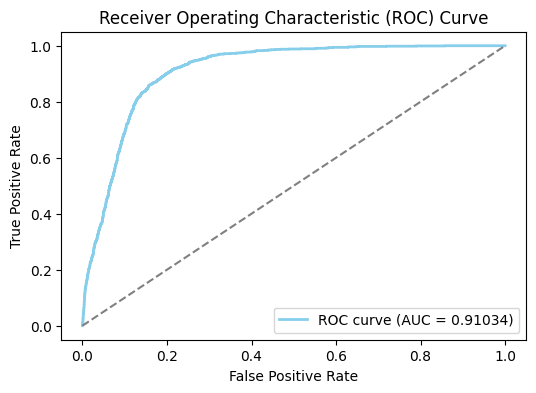

In [51]:
# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='skyblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Submission

In [52]:
# Predict on the transformed test dataset
test_pred = model.predict(test_transformed)

In [53]:
# Create a DataFrame for submission with 'id' and predicted 'target'
submission = pd.DataFrame({
    'id': range(0, test_df.shape[0]),
    'target': test_pred
})

# Save the submission to CSV
submission.to_csv('submission.csv', index=False)